## BOLT Bootcamp Competition 2023 - Team CAFE
**All source data can be found in the `data` folder**

In [1]:
# Additional dependencies that must be installed via pip or conda: openpyxl, matplotlib, seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math

In [2]:
# Creating base dataframes from the datasets
activity_df = pd.read_excel('data/Activity Table Dataset.xlsx')
case_df = pd.read_excel('data/case table.xlsx')
emissions_df = pd.read_excel('data/emission_by_activity.xlsx')
materials_df = pd.read_excel('data/material_costs.xlsx')

# Adding a 'Day' column to our Activity dataframe
activity_df['Day'] = activity_df['Timestamp'].apply(lambda x: x.date())
activity_df['Day'] = pd.to_datetime(activity_df['Day'])

# Joining Activity dataframe and Emissions dataframe on Activity/Activity Name
activity_emissions_df = pd.merge(activity_df, emissions_df, left_on='Activity Name', right_on='Activity', how='inner')
def avg_co2_vals(x):
    if isinstance(x, int) or isinstance(x, float):
        return x
    else:
        x, y = map(float, x.split(','))
        return x + (y / 10)

activity_emissions_df['CO2 Emissions (kg/tonne)'] = activity_emissions_df['CO2 Emissions (kg/tonne)'].apply(avg_co2_vals).astype(float)
activity_emissions_df = activity_emissions_df.sort_values(by='Sorting')

In [3]:
activity_df.head(3)

,Sorting,caseID,Activity Name,Timestamp,Day
0,0,1,Purchase Requisition Created,2021-05-03 17:30:00.000,2021-05-03
1,1,1,Purchase Order Reviewed,2021-05-03 17:30:00.000,2021-05-03
2,2,1,Purchase Order Approved,2021-05-07 20:18:39.610,2021-05-07


In [4]:
# Interesting that the activity_df and the case_df are related by the caseID attribute. 
# Some useful information can probably be extracted by merging these tables and visualizing them
case_df.head(3)

,Sorting,caseID,Material Code,Material,Vendor,Amount Ordered
0,0,1,CP4560,Titanium Dioxides,ColorPlus Manufacturing,13.649110
1,1,2,CP5644,Specialty Resins,ColorPlus Manufacturing,28.313711
2,2,3,SI8599,Solvents,Sunlight Industries,18.231351


In [5]:
# This table is also connected to the others.
# Joining it with the activity table for example could provide useful emission statistics
emissions_df.head(3)

,Activity,CO2 Emissions (kg/tonne)
0,Purchase Requisition Created,"0,1"
1,Purchase Order Reviewed,"0,1"
2,Purchase Order Approved,"0,1"


In [6]:
materials_df.head(3)

,Material,Price of Material (USD/tonne),Emission from Manufacturing (kg/tonne)
0,Latex & Monomers,"1049,96",231
1,Packaging,"1360,85",756
2,Solvents,"1169,79",210


In [7]:
activity_df.head(3)

,Sorting,caseID,Activity Name,Timestamp,Day
0,0,1,Purchase Requisition Created,2021-05-03 17:30:00.000,2021-05-03
1,1,1,Purchase Order Reviewed,2021-05-03 17:30:00.000,2021-05-03
2,2,1,Purchase Order Approved,2021-05-07 20:18:39.610,2021-05-07


In [8]:
activity_emissions_df.head(3)

,Sorting,caseID,Activity Name,Timestamp,Day,Activity,CO2 Emissions (kg/tonne)
0,0,1,Purchase Requisition Created,2021-05-03 17:30:00.000,2021-05-03,Purchase Requisition Created,0.1
2000,1,1,Purchase Order Reviewed,2021-05-03 17:30:00.000,2021-05-03,Purchase Order Reviewed,0.1
4000,2,1,Purchase Order Approved,2021-05-07 20:18:39.610,2021-05-07,Purchase Order Approved,0.1


## Analysis of the Activities dataset

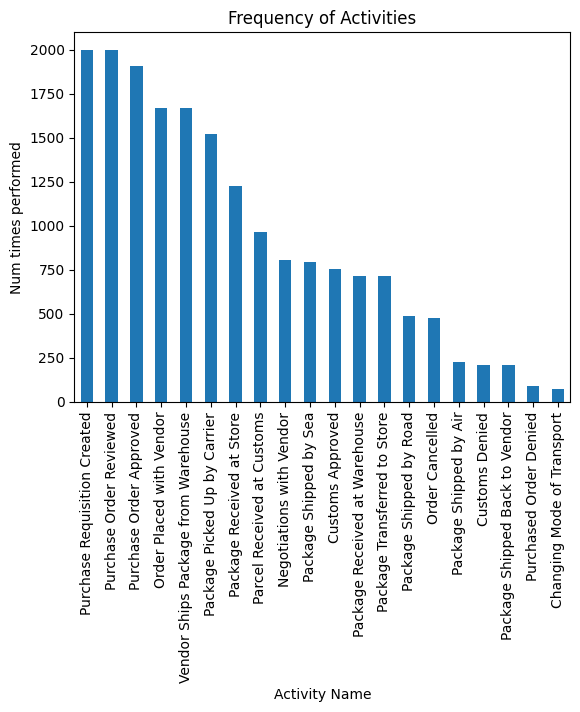

In [9]:
# Looking at the frequency of the various activities
activity_counts = activity_df['Activity Name'].value_counts()
activity_counts.plot(kind='bar')

plt.xlabel('Activity Name')
plt.ylabel('Num times performed')
plt.title('Frequency of Activities')
plt.show()

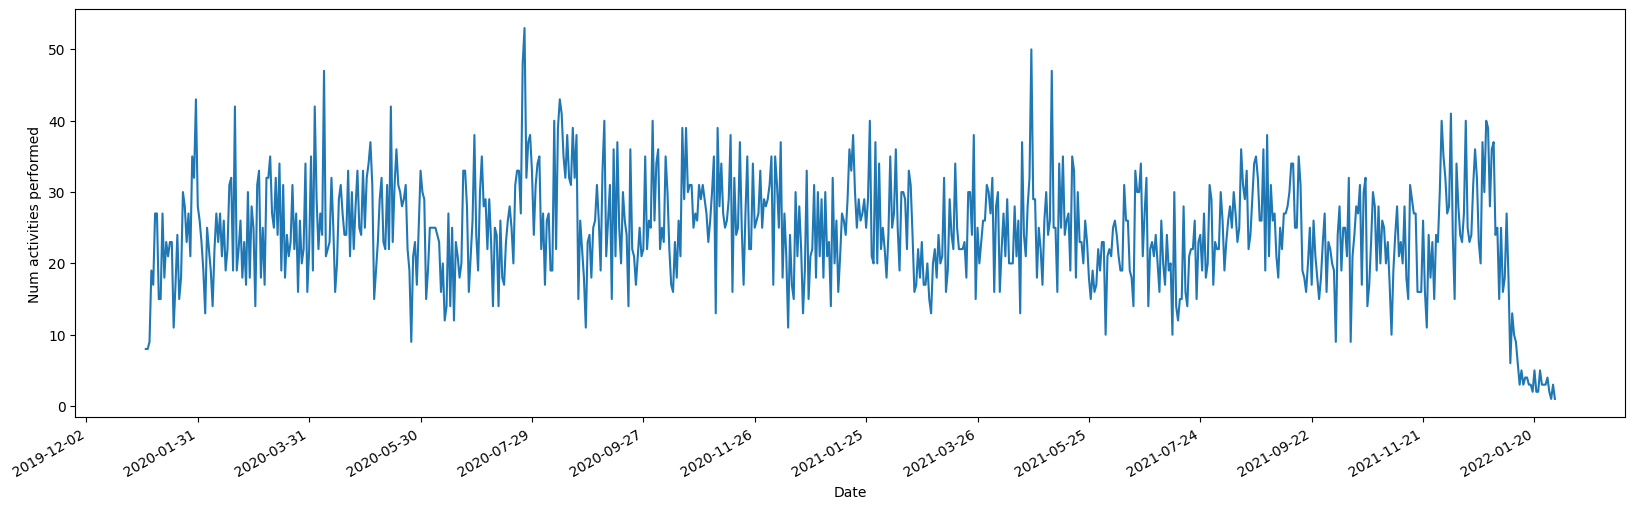

In [10]:
# Looking at the days on which the activities occur
fig = plt.figure(figsize=(20, 6))
day_counts = activity_df['Day'].value_counts()
day_counts.plot(kind='line')

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Num activities performed')
plt.show()

In [11]:
orders_df = activity_df[activity_df['Activity Name'] == 'Order Placed with Vendor']
orders_df = pd.merge(orders_df, case_df, on='caseID')
orders_df.shape

(1671, 10)

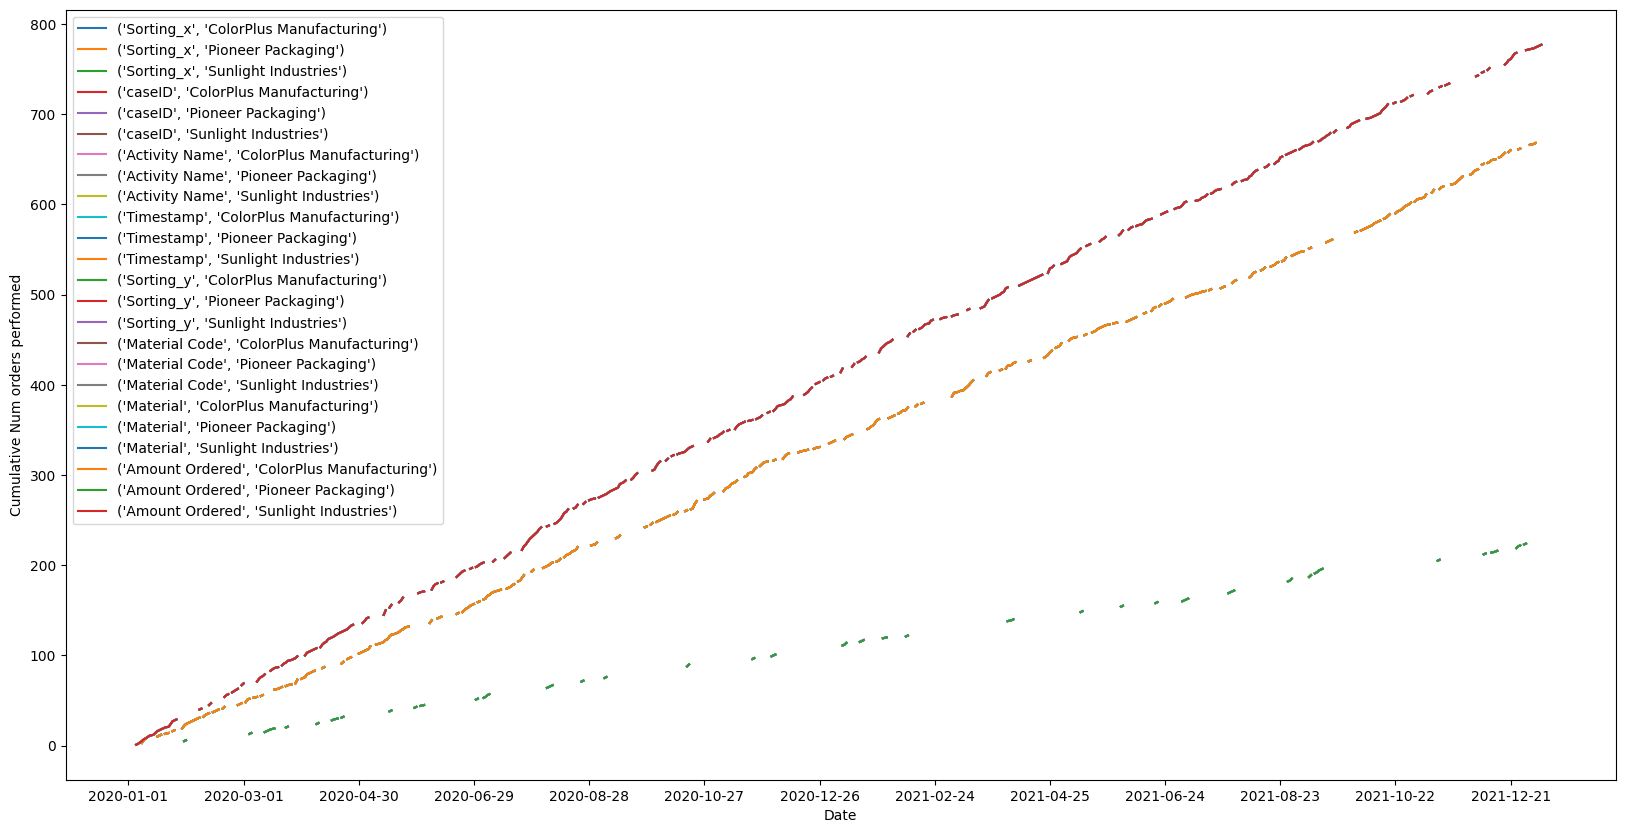

In [12]:
# Looking at orders per day by Vendor
fig = plt.figure(figsize=(20, 10))

orders_per_day_vendor = orders_df.groupby(['Day', 'Vendor']).count().unstack()

# calculate the cumulative sum of orders for each vendor
orders_per_day_vendor_cumulative = orders_per_day_vendor.cumsum()
# orders_per_day_vendor_cumulative = orders_per_day_vendor[['ColorPlus Manufacturing', 'Pioneer Packaging', 'Sunlight Industries']]

# plot each vendor's cumulative orders over time
for vendor in orders_per_day_vendor_cumulative.columns:
    plt.plot(orders_per_day_vendor_cumulative.index, orders_per_day_vendor_cumulative[vendor], label=vendor)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xlabel('Date')
plt.ylabel('Cumulative Num orders performed')
plt.legend()
plt.show()

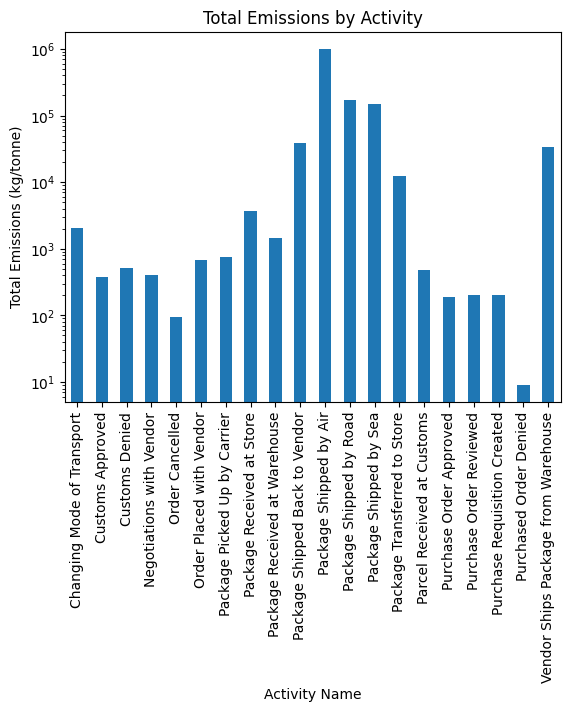

In [13]:
# Note that the chart below is logarithmically scaled
emissions_by_activity_log = activity_emissions_df.groupby('Activity Name')['CO2 Emissions (kg/tonne)'].sum()

emissions_by_activity_log.plot(kind='bar')
plt.xlabel('Activity Name')
plt.gca().set_yscale('log')
plt.ylabel('Total Emissions (kg/tonne)')
plt.title('Total Emissions by Activity')
plt.show()

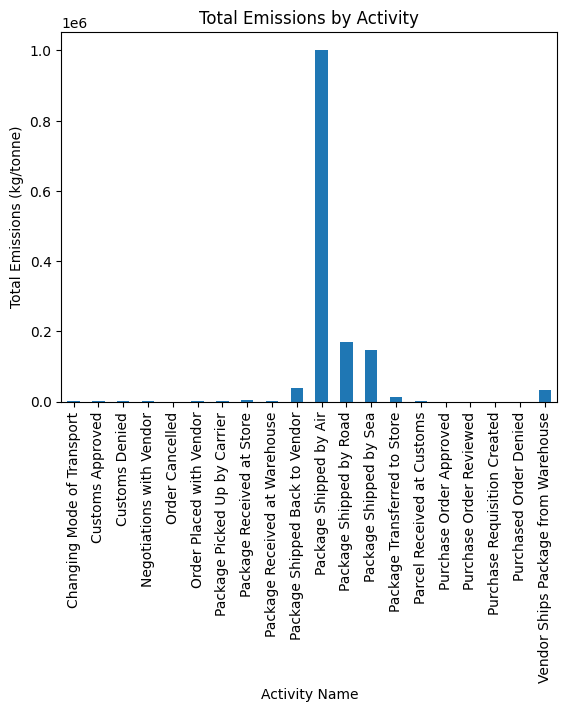

In [14]:
# Note that the chart below is a copy of the chart above but linearly scaled.
# It puts into perspective the massive emissions that come with shipping packages by air
emissions_by_activity_lin = activity_emissions_df.groupby('Activity Name')['CO2 Emissions (kg/tonne)'].sum()

emissions_by_activity_lin.plot(kind='bar')
plt.xlabel('Activity Name')
plt.ylabel('Total Emissions (kg/tonne)')
plt.title('Total Emissions by Activity')
plt.show()

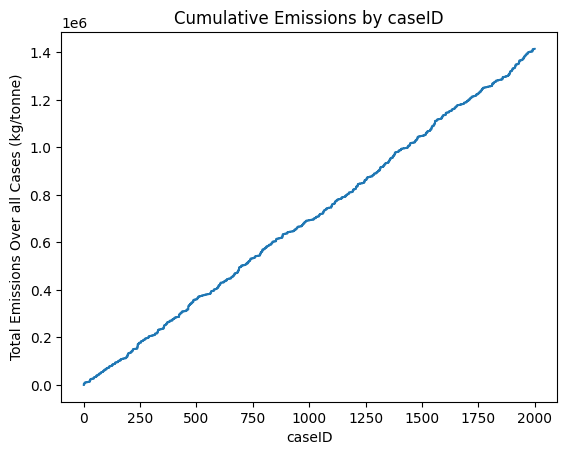

In [15]:
cumulative_emissions = activity_emissions_df['CO2 Emissions (kg/tonne)'].cumsum()
caseIDs = np.sort(activity_emissions_df['caseID'])

plt.plot(caseIDs, cumulative_emissions)
plt.xlabel('caseID')
plt.ylabel('Total Emissions Over all Cases (kg/tonne)')
plt.title('Cumulative Emissions by caseID')

plt.show()

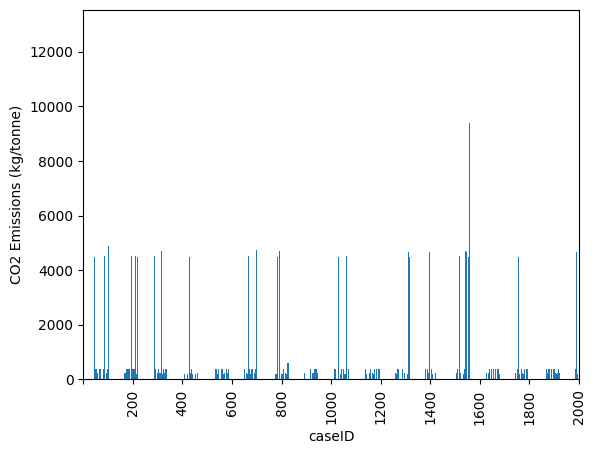

In [16]:
emissions_by_case = activity_emissions_df.groupby('caseID')['CO2 Emissions (kg/tonne)'].sum()
emissions_by_case.plot(kind='bar')
plt.xlabel('caseID')
plt.ylabel('CO2 Emissions (kg/tonne)')
plt.ylim([0, emissions_by_case.max()])
tick_positions = np.arange(-1, 2000, 200)
plt.xticks(tick_positions)
plt.show()

# Analysis of the Case dataset

In [17]:
# The table below has stats for each material in the case_df, note that values are rounded to round_dec places
round_dec = 3
mat_arr = case_df['Material'].unique()
material_stats = {"Material": mat_arr, 
                  "Avg order": [], 
                  "Std of order": [], 
                  "Std of order as % of avg": [],
                  "Num orders": [], 
                  "Largest order": [], 
                  "Smallest order": [],
                  "Total amount ordered": []}

for mat in mat_arr:
    avg_order = case_df.query(f'Material == "{mat}"')['Amount Ordered'].mean() # save as local var for use in other column
    material_stats[f"Avg order"].append(round(avg_order, round_dec))
    material_stats[f"Std of order"].append(round(case_df.query(f'Material == "{mat}"')['Amount Ordered'].std(), round_dec))
    material_stats[f"Std of order as % of avg"].append(round(case_df.query(f'Material == "{mat}"')['Amount Ordered'].std()/avg_order*100, round_dec))
    material_stats[f"Num orders"].append(len(case_df.query(f'Material == "{mat}"')['Amount Ordered']))
    material_stats[f"Largest order"].append(round(case_df.query(f'Material == "{mat}"')['Amount Ordered'].max(), round_dec))
    material_stats[f"Smallest order"].append(round(case_df.query(f'Material == "{mat}"')['Amount Ordered'].min(), round_dec))
    material_stats[f"Total amount ordered"].append(round(case_df.query(f'Material == "{mat}"')['Amount Ordered'].sum(), round_dec))
    

pd.DataFrame(material_stats)

,Material,Avg order,Std of order,Std of order as % of avg,Num orders,Largest order,Smallest order,Total amount ordered
0,Titanium Dioxides,10.164,2.964,29.159,272,14.984,5.002,2764.515
1,Specialty Resins,29.218,8.817,30.176,275,44.983,15.012,8034.882
2,Solvents,38.082,12.652,33.224,270,59.941,15.224,10282.007
3,Pigments & Colorants,89.200,36.490,40.907,257,149.400,30.123,22924.516
4,Packaging,19.784,5.951,30.079,268,29.948,10.067,5302.014
5,Additives,43.428,20.271,46.677,241,79.945,10.057,10466.044
6,Commodity Resins,6.579,1.940,29.489,272,9.998,3.009,1789.409
7,Latex & Monomers,64.264,19.607,30.510,145,99.719,30.537,9318.287


In [18]:
materials_arr = orders_df['Material'].unique()
orders_copy = orders_df.copy()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
materials_per_month = {'Month': months}
amt_per_month = {'Month': months}
orders_copy['Month'] = orders_copy['Day'].dt.strftime('%B')

for mat in materials_arr:
    materials_per_month[f"{mat}"] = []
    amt_per_month[f"{mat}"] = []
    for month in months:
        materials_per_month[f"{mat}"].append(len(orders_copy[(orders_copy['Month'] == month) & (orders_copy['Material'] == mat)]))
        amt_per_month[f"{mat}"].append(orders_copy[(orders_copy['Month'] == month) & (orders_copy['Material'] == mat)]['Amount Ordered'].sum())
        
mpm_df = pd.DataFrame.from_dict(materials_per_month)
apm_df = pd.DataFrame.from_dict(amt_per_month)
mpm_df.index = mpm_df.index + 1
apm_df.index = apm_df.index + 1
mpm_df.head()

,Month,Titanium Dioxides,Specialty Resins,Solvents,Pigments & Colorants,Packaging,Commodity Resins,Latex & Monomers,Additives
1,January,22,19,24,15,17,29,8,20
2,February,17,15,13,12,15,13,14,17
3,March,21,20,14,19,17,22,9,15
4,April,18,19,17,17,21,21,13,15
5,May,17,24,22,17,17,17,9,20


In [19]:
avg_order = mpm_df.mean()
avg_order

/var/folders/6b/lg4d_y9j47b0y3w_qsj73stc0000gn/T/ipykernel_87565/2938534960.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avg_order = mpm_df.mean()


Titanium Dioxides       19.500000
Specialty Resins        18.916667
Solvents                18.500000
Pigments & Colorants    17.416667
Packaging               18.666667
Commodity Resins        18.750000
Latex & Monomers        10.416667
Additives               17.083333
dtype: float64

In [20]:
mat_emissions_df = pd.merge(activity_emissions_df, case_df, on='caseID')
mat_emissions_df.tail(30)

,Sorting_x,caseID,Activity Name,Timestamp,Day,Activity,CO2 Emissions (kg/tonne),Sorting_y,Material Code,Material,Vendor,Amount Ordered
18473,18473,1998,Purchase Requisition Created,2021-12-25 23:52:00.000,2021-12-25,Purchase Requisition Created,0.1,1997,CP5644,Specialty Resins,ColorPlus Manufacturing,42.847274
18474,18474,1998,Purchase Order Reviewed,2021-12-25 23:52:00.000,2021-12-25,Purchase Order Reviewed,0.1,1997,CP5644,Specialty Resins,ColorPlus Manufacturing,42.847274
18475,18475,1998,Purchase Order Approved,2021-12-28 14:51:28.930,2021-12-28,Purchase Order Approved,0.1,1997,CP5644,Specialty Resins,ColorPlus Manufacturing,42.847274
18476,18476,1998,Negotiations with Vendor,2021-12-28 22:06:38.199,2021-12-28,Negotiations with Vendor,0.5,1997,CP5644,Specialty Resins,ColorPlus Manufacturing,42.847274
18477,18477,1998,Order Cancelled,2022-01-02 13:59:56.179,2022-01-02,Order Cancelled,0.2,1997,CP5644,Specialty Resins,ColorPlus Manufacturing,42.847274
18478,18478,1999,Purchase Requisition Created,2021-01-03 07:54:00.000,2021-01-03,Purchase Requisition Created,0.1,1998,PO9342,Packaging,Pioneer Packaging,20.675410
18479,18479,1999,Purchase Order Reviewed,2021-01-03 07:54:00.000,2021-01-03,Purchase Order Reviewed,0.1,1998,PO9342,Packaging,Pioneer Packaging,20.675410
18480,18480,1999,Purchase Order Approved,2021-01-04 22:33:19.267,2021-01-04,Purchase Order Approved,0.1,1998,PO9342,Packaging,Pioneer Packaging,20.675410
18481,18481,1999,Order Placed with Vendor,2021-01-05 04:35:04.864,2021-01-05,Order Placed with Vendor,0.4,1998,PO9342,Packaging,Pioneer Packaging,20.675410
18482,18482,1999,Vendor Ships Package from Warehouse,2021-01-05 10:41:20.650,2021-01-05,Vendor Ships Package from Warehouse,20.0,1998,PO9342,Packaging,Pioneer Packaging,20.675410


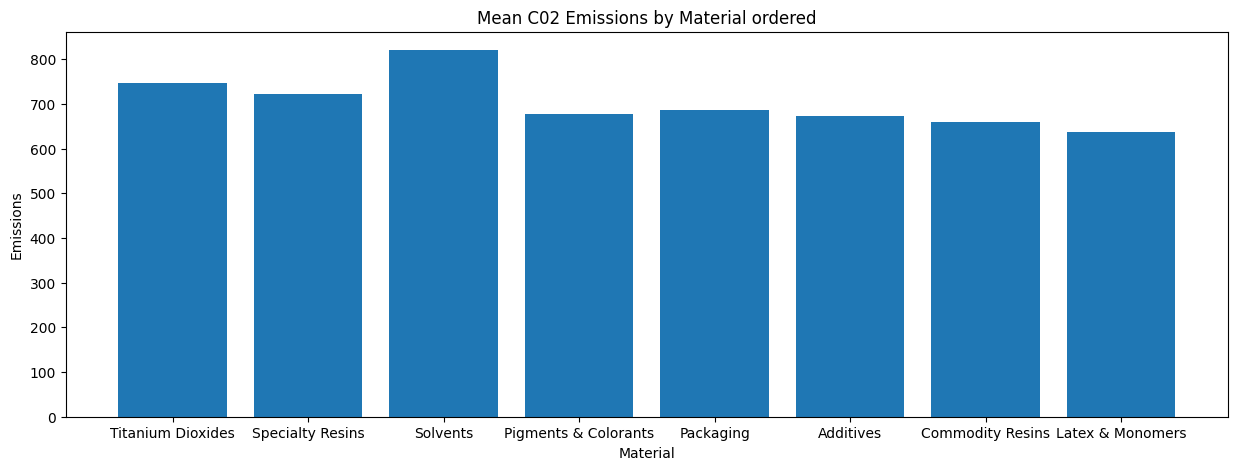

In [21]:
emissions_by_mat = {}
for mat in mat_emissions_df['Material'].unique():
    num_mat_cases = len(mat_emissions_df[mat_emissions_df['Material'] == mat]['caseID'].unique())
    emissions_by_mat[mat] = round(mat_emissions_df[mat_emissions_df['Material'] == mat]['CO2 Emissions (kg/tonne)'].sum() / num_mat_cases, 1)

fig, ax = plt.subplots(figsize=(15, 5))
plt.bar(emissions_by_mat.keys(), emissions_by_mat.values())
plt.xlabel('Material')
plt.ylabel('Emissions')
plt.title('Mean C02 Emissions by Material ordered')
plt.show()

In [22]:
emissions_by_mat

{'Titanium Dioxides': 747.6,
 'Specialty Resins': 721.2,
 'Solvents': 820.4,
 'Pigments & Colorants': 677.5,
 'Packaging': 686.4,
 'Additives': 673.1,
 'Commodity Resins': 658.4,
 'Latex & Monomers': 637.8}

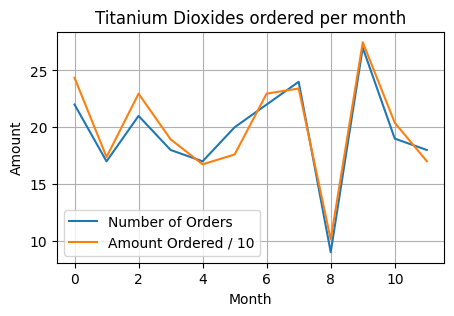

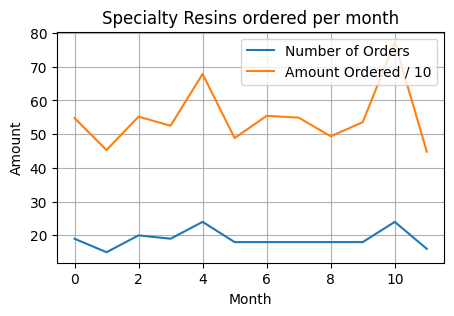

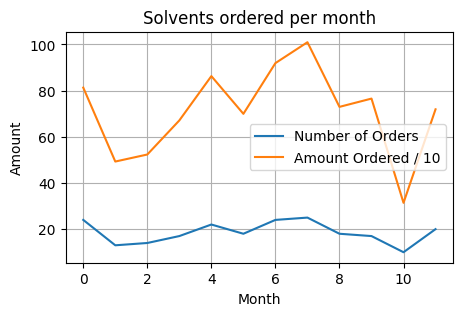

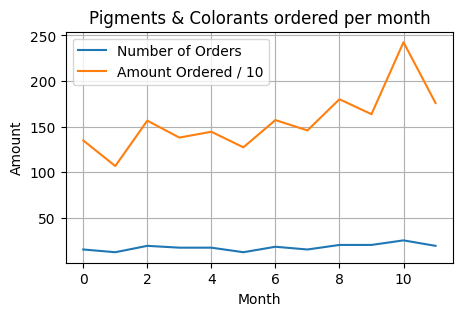

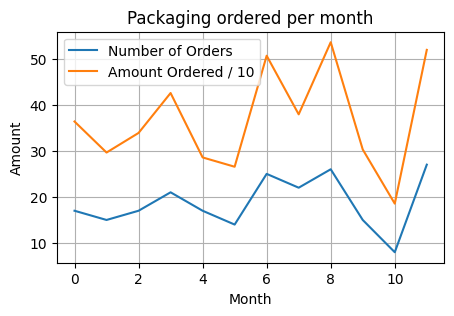

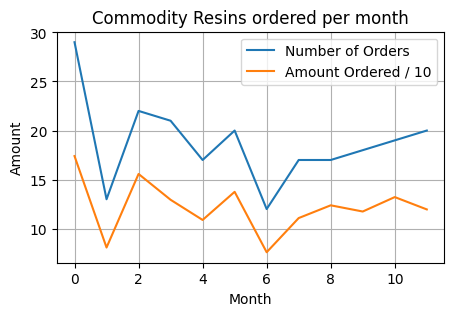

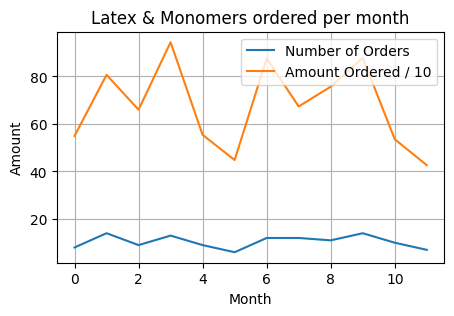

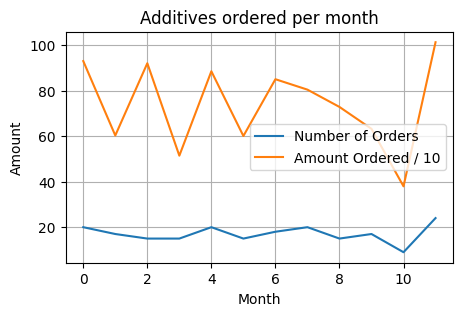

In [23]:
for mat in mpm_df.columns[1:]:
    x = np.array(range(len(mpm_df.index)))
    y = mpm_df[mat].values
    
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(x, y, label='Number of Orders')
    ax.plot(x, apm_df[mat].values / 10, label='Amount Ordered / 10')
    ax.set_xlabel('Month')
    ax.set_ylabel('Amount')
    ax.set_title(f"{mat} ordered per month")
    ax.grid(True)
    ax.legend()
    plt.show()

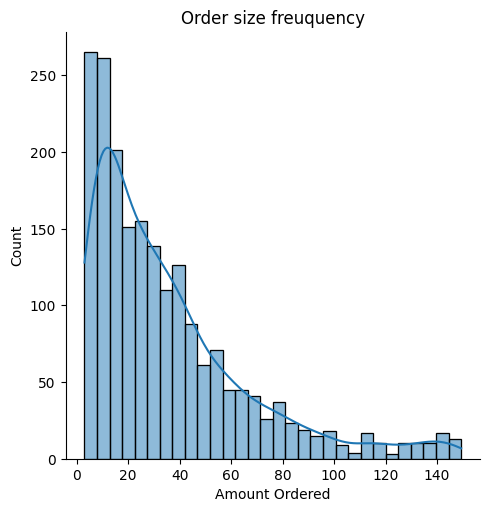

In [24]:
sns.displot(case_df['Amount Ordered'], kde=True, bins=30);
plt.title("Order size freuquency")
plt.show()

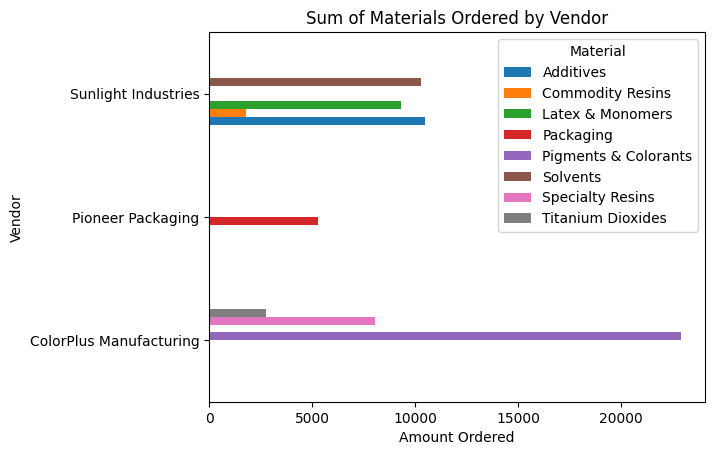

In [25]:
case_pivot_table = pd.pivot_table(case_df, values='Amount Ordered', index='Vendor', columns='Material', aggfunc='sum')
case_pivot_table.plot(kind='barh')

plt.xlabel('Amount Ordered')
plt.ylabel('Vendor')
plt.title('Sum of Materials Ordered by Vendor')
plt.show()

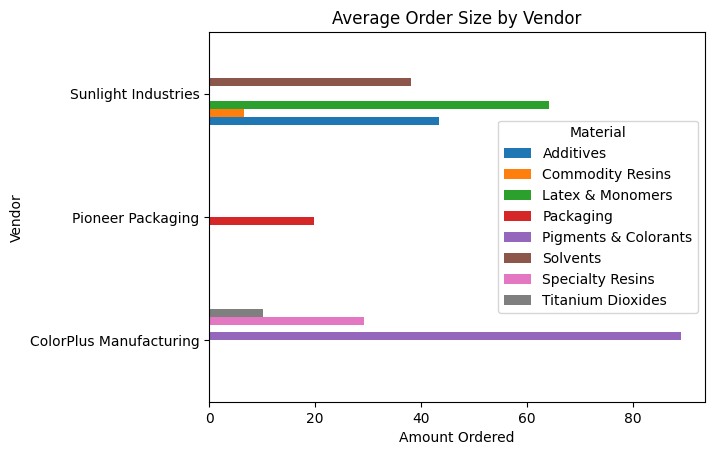

In [26]:
case_pivot_table_1 = pd.pivot_table(case_df, values='Amount Ordered', index='Vendor', columns='Material', aggfunc='mean')
case_pivot_table_1.plot(kind='barh')

plt.xlabel('Amount Ordered')
plt.ylabel('Vendor')
plt.title('Average Order Size by Vendor')
plt.show()

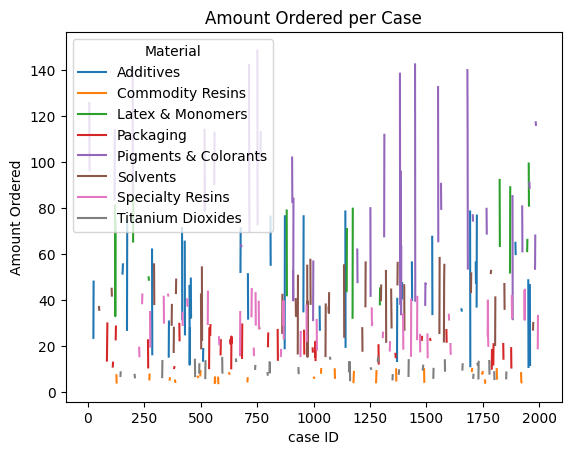

In [27]:
case_pivot_table_2 = pd.pivot_table(case_df, values='Amount Ordered', index='caseID', columns='Material', aggfunc=np.sum)

case_pivot_table_2.plot()
plt.xlabel('case ID')
plt.ylabel('Amount Ordered')
plt.title('Amount Ordered per Case')
plt.show()